In [1]:
from dataset.translate import *

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from sklearn.metrics import classification_report

# Import data

In [2]:
def translate_label(dirname: str, mapping: dict[str, str]) -> str:
    translated = mapping.get(dirname, dirname)
    return translated

In [3]:
df = pd.DataFrame()
data = []

for (dirpath, dirnames, filenames) in os.walk("./dataset/raw-img"):
    if filenames:
        label = os.path.basename(dirpath)
        translated_label = translate_label(label, translate_it_to_en)
        for filename in filenames:
            filepath = os.path.join(dirpath, filename)
            data.append({'label': translated_label, 'filepath': filepath})

df = pd.DataFrame(data)
df

,label,filepath
0,squirrel,./dataset/raw-img/scoiattolo/OIP-i9HgaFN9sduzt...
1,squirrel,./dataset/raw-img/scoiattolo/OIP-koCqXcAmo4Ist...
2,squirrel,./dataset/raw-img/scoiattolo/OIP-haxSd1cvUcBow...
3,squirrel,./dataset/raw-img/scoiattolo/OIP-hNvyhaimS5BgV...
4,squirrel,./dataset/raw-img/scoiattolo/OIP-ypvnupPWTKy39...
...,...,...
26174,chicken,./dataset/raw-img/gallina/OIP-bxXKOks26GUjYtvr...
26175,chicken,./dataset/raw-img/gallina/OIP-vp9fv_4MqnJ_Oox3...
26176,chicken,./dataset/raw-img/gallina/307.jpeg
26177,chicken,./dataset/raw-img/gallina/OIP-pQu0Qv-1hQpvnNg3...


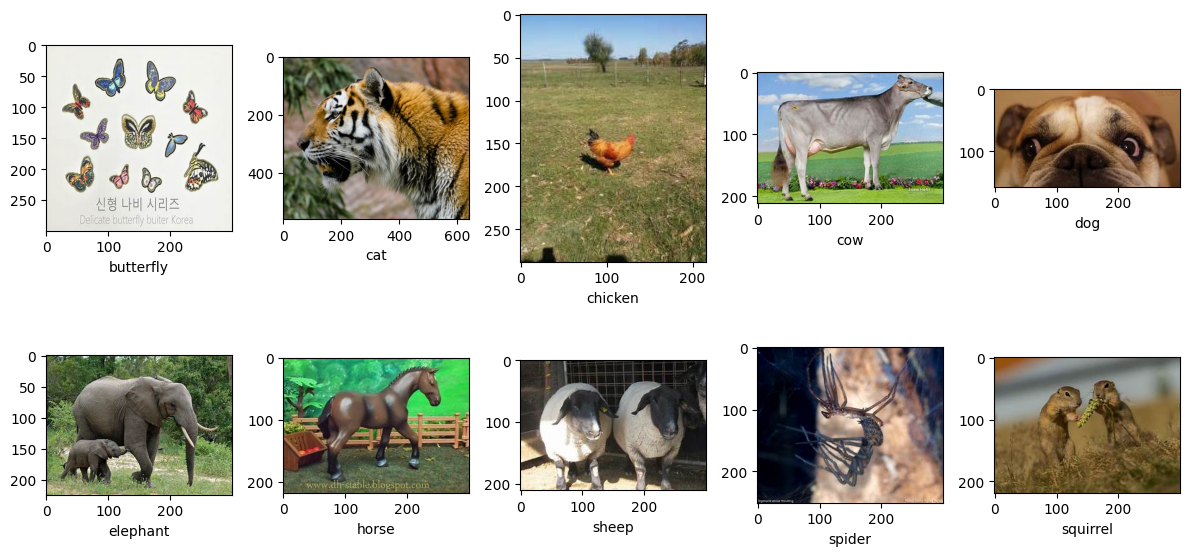

In [4]:
sample_df = df.groupby('label').first().reset_index()
_, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, (index, row) in enumerate(sample_df.iterrows()):
    filename =  row["filepath"] # type: ignore
    category =  row["label"] # type: ignore
    img = Image.open(filename).convert("RGB")
    axes[i//5, i%5].imshow(img)
    axes[i//5, i%5].set_xlabel(category)
plt.tight_layout()
plt.show()

# Label encoding

In [5]:
labelEncoding = {label: str(idx) for idx, label in enumerate(df['label'].unique())}
df['label_encoded'] = df['label'].map(labelEncoding)
df.groupby('label_encoded').first().head(df['label'].nunique())

,label,filepath
label_encoded,,
0,squirrel,./dataset/raw-img/scoiattolo/OIP-i9HgaFN9sduzt...
1,sheep,./dataset/raw-img/pecora/OIP-BrDFv_baFmMXjFDiq...
2,elephant,./dataset/raw-img/elefante/OIP-QxS-o3z04XXazE5...
3,spider,./dataset/raw-img/ragno/OIP-Krduk91xOsghW2IUsG...
4,cow,./dataset/raw-img/mucca/OIP-n-bHpA3RDEIHiPJ0dx...
5,horse,./dataset/raw-img/cavallo/OIP-qLAt_e5qsVaZs8VJ...
6,butterfly,./dataset/raw-img/farfalla/OIP-DBfUbwR8kJ9INwd...
7,cat,./dataset/raw-img/gatto/ea36b70f2df2013ed1584d...
8,dog,./dataset/raw-img/cane/OIP-Chbai5ssqMEVxCBzZ2F...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26179 entries, 0 to 26178
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   label          26179 non-null  object
 1   filepath       26179 non-null  object
 2   label_encoded  26179 non-null  object
dtypes: object(3)
memory usage: 613.7+ KB


# Splitting data

In [ ]:
def split_data(df: pd.DataFrame, test_size: float, val_size: float, random_state: int):
    train_val_df, test_df = train_test_split(
        df,
        test_size=test_size,
        stratify=df['label_encoded'],
        random_state=random_state
    )

    val_relative_size = val_size / (1 - test_size)

    train_df, val_df = train_test_split(
        train_val_df,
        test_size=val_relative_size,
        stratify=train_val_df['label_encoded'],
        random_state=random_state
    )

    train_x = train_df['filepath']
    train_y = train_df['label_encoded']

    val_x = val_df['filepath']
    val_y = val_df['label_encoded']

    test_x = test_df['filepath']
    test_y = test_df['label_encoded']

    return train_x, train_y, val_x, val_y, test_x, test_y

In [8]:
train_x, train_y, val_x, val_y, test_x, test_y = split_data(df, test_size=0.3, val_size=0.2, random_state=880055535)

# Pipeline transformations

In this part we want to find mean / std for our dataset for normalization

In [9]:
from image_dataset import ImageDataset
tr = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = ImageDataset(train_x, train_y, transform=tr)
loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)

mean = 0.
std = 0.
total_images = 0

for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images += batch_samples

mean /= total_images
std /= total_images
print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: tensor([0.5198, 0.5022, 0.4144])
Std: tensor([0.2085, 0.2081, 0.2100])


now we can add normaliser for all pipelines

In [10]:
tr_norm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [11]:
train_dataset = ImageDataset(val_x, val_y, transform=tr)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

train_dataset_norm = ImageDataset(val_x, val_y, transform=tr_norm)
train_loader_norm = DataLoader(train_dataset_norm, batch_size=64, shuffle=True, num_workers=4)

test_dataset = ImageDataset(test_x, test_y, transform=tr_norm)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

In [12]:
device = torch.device(device="cuda" if torch.cuda.is_available() else "cpu")
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 32 * 32, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
def predict_all(model, loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            logits = model(x)
            p = torch.argmax(logits, dim=1)
            preds.extend(p.cpu().numpy())
    return np.array(preds)

In [15]:
num_classes = len(labelEncoding)

In [ ]:
def train(model: nn.Module, optimizer: torch.optim.Optimizer, criterion: nn.Module, train_loader: DataLoader, num_epochs=5):
    loss_vals=  []
    for epoch in range(num_epochs):
        loss = 0
        epoch_loss= []
        for batch, (data, targets) in enumerate(train_loader):
            data = data.to(device=device)
            targets = targets.to(device=device)
            
            #Forward pass
            scores = model(data)
            loss = criterion(scores, targets)
            
            #Backward pass
            optimizer.zero_grad()
            loss.backward()
            
            epoch_loss.append(loss.item())
            
            # Gradient descent
            optimizer.step()
            
        loss_vals.append(sum(epoch_loss)/len(epoch_loss))
        print(epoch, "Current Loss:", loss)
    return loss_vals

def evaluate(loader, model):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            
            scores = model(x)
            _, pred = scores.max(1)
            correct += (pred == y).sum()
            total += pred.size(0)
        print("Accuracy:", correct/total*100, "%")

In [ ]:
# for name, loader in zip(["regular", "norm"], [train_loader, train_loader_norm]):
#     model = SimpleCNN(num_classes).to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#     criterion = nn.CrossEntropyLoss()
#     loss_res = []
#     for epoch in range(5):
#         print(f"Starting epoch {epoch} for loader {name}")
#         model.train()
#         for x, y in loader:
#             x = x.to(device)
#             if isinstance(y, torch.Tensor):
#                 y = y.to(device)
#             else:
#                 y = torch.tensor([int(label) for label in y], dtype=torch.long, device=device)
#             optimizer.zero_grad()
#             logits = model(x)
#             loss = criterion(logits, y)
#             loss.backward()
#             optimizer.step()
#             loss_res.append(loss.item())

#     sns.lineplot(x=range(len(loss_res)), y=loss_res, label=f"Loss {name}")

#     preds = predict_all(model, test_loader, device)
#     true_labels = []
#     for _, y in test_loader:
#         if isinstance(y, torch.Tensor):
#             true_labels.extend(y.cpu().numpy())
#         else:
#             true_labels.extend(np.array(y, dtype=np.int64))
#     true_labels = np.array(true_labels)

#     print(name)
#     print(classification_report(true_labels, preds, digits=4))

Starting epoch 0 for loader regular


KeyboardInterrupt: 

Adam was used because nowadays it is mostly used optimizer. It combines RMSProp with momentum and bias correction, which adjusts the deviations at the start of the algorithm and speeds up the convergence

## Training the model for check the difference between pipelines with and without normalization

In [ ]:
model_regular = SimpleCNN(num_classes).to(device)
loss_vals_regular = train(model_regular, torch.optim.Adam(model_regular.parameters(), lr=1e-3), nn.CrossEntropyLoss(), train_loader)
model_norm = SimpleCNN(num_classes).to(device)
loss_vals_norm = train(model_norm, torch.optim.Adam(model_norm.parameters(), lr=1e-3), nn.CrossEntropyLoss(), train_loader_norm)

after we train our model we can evaluate it on train and test datasets, so we can check if there any difference in accuracy between pipelines with and without normalization

In [ ]:
sns.lineplot(x=range(len(loss_vals_regular)), y=loss_vals_regular, label="Loss regular")
sns.lineplot(x=range(len(loss_vals_norm)), y=loss_vals_norm, label="Loss normalized")

## Evaluating the model for both pipelines

In [ ]:
evaluate(train_loader, model_regular)
evaluate(test_loader, model_regular)
evaluate(train_loader, model_norm)
evaluate(test_loader, model_norm)